
# Arrival delay vs swarm size (SR BO for retardant drops)



## Experiment design
- Evidence-based parameters (CFA slope rule, Tolhurst ROS scale, MAFFS-like retardant footprint, long half-life) with a single tuning cell.
- Visual sanity checks: ignition + baseline spread without suppression, search grid overlay.
- Heuristic gallery: 10 heuristic placements (2x5 grid) on a representative setting.
- BO diagnostics per setting: hyperparameters, learning curve, scenario outcome.
- Cross-setting assessment: phase diagrams/heatmaps + best-overall snapshot.



### Evidence-based parameter choices
The environment and suppression parameters are chosen to be consistent with publicly documented fire and retardant behaviour. Firstly, slope sensitivity follows the Victorian CFA rule-of-thumb that the local rate of spread $\mathrm{ROS}$ approximately doubles for each $10^\circ$ increase in upslope \cite{CFAFireBehaves}. Secondly, the baseline $\mathrm{ROS}$ is calibrated to extreme short-duration values reported in Victorian fire behaviour analyses (used here as a reference scale) \cite{Tolhurst2009}. For retardant, persistence is modelled using a long half-life $t_{1/2}$, meaning that retardant remains effective until significant rainfall \cite{PerimeterPhosChekFAQ}. Finally, the order of magnitude of the drop footprint $(w_d, h_d)$ follows MAFFS coverage dimensions (physical length $\approx 0.4~\mathrm{km}$ and width $\approx 0.02~\mathrm{km}$), mapped onto the discretised grid abstraction \cite{USAFMAFFS}.


In [117]:

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.exceptions import ConvergenceWarning
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel

from fire_model.ca import FireEnv, CAFireModel
from fire_model.bo_sr import RetardantDropBayesOptSR, TiedSRDeltaMatern

# Suppress noisy optimisation warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*Optimal value found for.*")
warnings.filterwarnings("ignore", message=".*Predicted variances smaller than observation noise.*")


In [118]:
import warnings
warnings.filterwarnings("ignore", message=".*balance properties of Sobol.*")


In [119]:

# Master configuration (tune everything here).
CONFIG = {
    "grid": {
        "size": (100, 100),
        "domain_km": 3.0,
        "dt_s": 10.0,
    },
    "fire": {
        "ros_mps": 0.1,  # steady-state ROS (Tolhurst 2009)
        "ros_accel_tau_s": 1200.0,  # time constant for ROS ramp-up from ignition (None/<=0 disables)
        "wind": (0.35, 0.10),
        "burn_time_s0": 600.0,
        "retardant_half_life_s": 7200.0,
        "retardant_k": 1.0,
        "retardant_cell_cap": 2.5,
        "wind_coeff": 0.55,
        "drop_w_km": 0.04,
        "drop_h_km": 0.40,
        "drop_amount": 1.0,
        "avoid_burning_drop": True,
    },
    "ignition": {
        "center_frac": (0.42, 0.45),
        "radius_km": 0.05,  # very small ignition
    },
    "sweep": {
        "time_of_arrival_s": [300.0, 600.0, 900.0, 1200.0, 1500.0, 2100.0, 2400.0],
        "drone_counts": [2,4,6,8,10],
        "horizon_total_s": 3600.0,
        "horizon_s": 720.0,
        "n_mc": 10,
        "seed": 5,
    },
    "diagnostics": {
        "settings": [(60.0, 2), (300.0, 4)],  # per-run plots (toggle to taste)
        "horizon_total_s": 4800.0,
        "horizon_s": 720.0,
        "n_mc": 20,
    },
    "search_grid": {
        "fire_boundary_probability": 0.25,
        "K_grid": 100,
        "boundary_field": "affected",
        "n_r": 100,
        "smooth_iters": 200,
        "omega": 1.0,
    },
    "bo": {
        "n_init": 25,
        "n_iters": 100,
        "n_candidates": 2**12,
        "xi": 0.03,
        "use_ard_kernel": False,
        "candidate_strategy": "mixed",
        "candidate_qmc": "sobol",
        "candidate_local_frac": 0.6,
        "candidate_local_top_k": 6,
        "candidate_local_sigma_s": 0.02,
        "candidate_local_sigma_r": 0.02,
        "candidate_local_sigma_delta_rad": np.deg2rad(5.0),
        "candidate_local_resample_delta_prob": 0.05,
        "init_strategy": "heuristic",
        "init_heuristic_random_frac": 0.4,
        "init_heuristic_kwargs":  {"value_power": 2.4, "r_offset": -0.02, "jitter_delta_rad": np.deg2rad(6.0), "uniform_ring_jitter_s": 0.15, "uniform_ring_jiter_r": 0.05, "downwind_line_wind_bias": 3.0, "downwind_line_jitter_r": 0.2, "heuristic_mix_prob":0.3},
        "init_heuristic_value_prob": 0.0,
        "init_heuristic_uniform_ring_prob": 0.5,
        "init_heuristic_downwind_prob": 0.5,
    },
    "heuristics": {
        "n_evals": 10,
        "heuristic_random_frac": 0.4,
        "heuristic_kwargs": {"value_power": 2.4, "r_offset": -0.02, "jitter_delta_rad": np.deg2rad(8.0), "uniform_ring_jitter_s": 0.15, "uniform_ring_jiter_r": 0.05, "downwind_line_wind_bias": 3.0, "downwind_line_jitter_r": 0.2},
        "heuristic_value_prob": 0,
        "heuristic_uniform_ring_prob": 0.5,
        "heuristic_downwind_prob": 0.5,
        "heuristic_mix_prob": 0.3,
        "heuristic_mix_ratio": 0.5,
    },
    "plots": {
        "example_n_sims": 20,
        "heuristic_figsize": (14, 6),
        "bo_outcome_n_sims": 20,
    },
}


In [120]:
# Helper functions (build env, rollouts, BO wrapper, plotting helpers).

def sr_kwargs(cfg):
    sg = cfg.get("search_grid", {})
    return {
        "K": sg.get("K_grid", sg.get("K", 500)),
        "boundary_field": sg.get("boundary_field", "affected"),
        "n_r": sg.get("n_r", 160),
        "smooth_iters": sg.get("smooth_iters", 350),
        "omega": sg.get("omega", 1.0),
    }

def ignition_center_px(cfg):
    nx, ny = cfg["grid"]["size"]
    fx, fy = cfg["ignition"]["center_frac"]
    return (int(fx * nx), int(fy * ny))

def build_ros_schedule(cfg):
    base = cfg["fire"].get("ros_mps", 0.5)
    tau = cfg["fire"].get("ros_accel_tau_s", None)
    if tau is None or tau <= 0.0:
        return base
    dt = cfg["grid"]["dt_s"]
    arrivals = list(cfg["sweep"].get("time_of_arrival_s", []))
    arrivals.extend([a for a, _ in cfg.get("diagnostics", {}).get("settings", [])])
    max_arrival = max(arrivals) if arrivals else 0.0
    horizons = [cfg["sweep"].get("horizon_total_s", cfg["sweep"].get("horizon_s", 0.0)), cfg.get("diagnostics", {}).get("horizon_s", 0.0)]
    total_time = max_arrival + max(horizons)
    steps = int(np.ceil(total_time / dt)) + 1
    t = np.arange(steps) * dt
    accel = 1.0 - np.exp(-t / tau)
    return base * accel

def build_fire_model(cfg, seed: int = 0) -> CAFireModel:
    nx, ny = cfg["grid"]["size"]
    fuel = np.ones((nx, ny), dtype=float)
    value = np.ones_like(fuel)
    wind_field = np.zeros((nx, ny, 2), dtype=float)
    wind_field[..., 0] = cfg["fire"]["wind"][0]
    wind_field[..., 1] = cfg["fire"]["wind"][1]

    env = FireEnv(
        grid_size=(nx, ny),
        domain_km=cfg["grid"]["domain_km"],
        fuel=fuel,
        value=value,
        wind=wind_field,
        dt_s=cfg["grid"]["dt_s"],
        burn_time_s0=cfg["fire"]["burn_time_s0"],
        retardant_half_life_s=cfg["fire"]["retardant_half_life_s"],
        retardant_k=cfg["fire"]["retardant_k"],
        drop_w_km=cfg["fire"]["drop_w_km"],
        drop_h_km=cfg["fire"]["drop_h_km"],
        drop_amount=cfg["fire"]["drop_amount"],
        ros_mps=build_ros_schedule(cfg),
        wind_coeff=cfg["fire"]["wind_coeff"],
        diag=True,
        avoid_burning_drop=cfg["fire"]["avoid_burning_drop"],
        avoid_drop_p_threshold=0.25,
        retardant_cell_cap=cfg["fire"].get("retardant_cell_cap", None),
    )
    return CAFireModel(env, seed=seed)

def rollout_to_arrival(fire_model: CAFireModel, time_of_arrival_s: float, *, n_mc: int, seed: int) -> object:
    center = ignition_center_px(CONFIG)
    radius_km = CONFIG["ignition"]["radius_km"]
    init_batch = fire_model.init_state_batch(n_sims=n_mc, center=center, radius_km=radius_km)
    return fire_model.simulate_from_firestate(
        init_batch,
        T=time_of_arrival_s,
        n_sims=n_mc,
        drone_params=None,
        ros_mps=fire_model.env.ros_mps,
        wind_coeff=fire_model.env.wind_coeff,
        diag=True,
        seed=seed,
        avoid_burning_drop=CONFIG["fire"]["avoid_burning_drop"],
    )

def expected_burned_km2(fire_model: CAFireModel, firestate) -> float:
    p_burning = np.asarray(firestate.burning[0], dtype=float)
    p_burned = np.asarray(firestate.burned[0], dtype=float)
    p_aff = np.clip(p_burning + p_burned, 0.0, 1.0)
    dx = fire_model.env.domain_km / fire_model.env.grid_size[0]
    return float(np.sum(p_aff * fire_model.env.value) * (dx ** 2))

def make_bo_for_setting(time_of_arrival_s: float, n_drones: int, *, cfg=None, seed_offset: int = 0):
    cfg = CONFIG if cfg is None else cfg
    fm = build_fire_model(cfg, seed=cfg["sweep"]["seed"] + seed_offset)
    arrival_state = rollout_to_arrival(
        fm,
        time_of_arrival_s,
        n_mc=cfg["sweep"]["n_mc"],
        seed=cfg["sweep"]["seed"] + seed_offset,
    )
    total_horizon = cfg["sweep"].get("horizon_total_s", cfg["sweep"].get("horizon_s", 0.0))
    horizon_after = max(total_horizon - time_of_arrival_s, 0.0)
    bo = RetardantDropBayesOptSR(
        fire_model=fm,
        init_firestate=arrival_state,
        n_drones=int(n_drones),
        evolution_time_s=horizon_after,
        n_sims=cfg["sweep"]["n_mc"],
        fire_boundary_probability=cfg["search_grid"].get("fire_boundary_probability", 0.3),
        search_grid_evolution_time_s=cfg["search_grid"].get("evolution_time_s", horizon_after),
        rng=np.random.default_rng(cfg["sweep"]["seed"] + seed_offset + 2),
    )
    return bo, arrival_state

def eval_theta_fields(bo: RetardantDropBayesOptSR, theta, n_sims: int | None = None):
    params = bo.decode_theta(theta)
    evolved = bo._simulate_firestate_with_params(params, n_sims=n_sims)
    p_aff = np.clip(evolved.burning[0] + evolved.burned[0], 0.0, 1.0)
    obj = bo._expected_value_from_firestate(evolved)
    return obj, p_aff, evolved

def fit_gp_from_history(history, *, use_ard: bool = False):
    X, y = history
    if use_ard:
        base_kernel = Matern(length_scale=np.ones(X.shape[1], dtype=float), nu=2.5, length_scale_bounds=(1e-3, 1e3))
    else:
        base_kernel = TiedSRDeltaMatern(ls=0.2, lr=0.2, ldelta=0.5, nu=2.5, length_scale_bounds=(1e-3, 1e3))
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * base_kernel + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=2, random_state=None)
    gp.fit(X, y)
    return gp

def plot_learning_curve(y_bests, title: str = "BO learning curve"):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(range(1, len(y_bests) + 1), y_bests, marker="o")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Best-so-far objective (km$^2$)")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_phase_diagram(df, *, title: str):
    pivot = df.pivot(index="n_drones", columns="time_of_arrival_s", values="relative_reduction") * 100.0
    fig, ax = plt.subplots(figsize=(8, 4.5))
    im = ax.imshow(pivot.values, origin="lower", aspect="auto", cmap="viridis")
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{c/60:.1f}" for c in pivot.columns])
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel("Time of arrival (minutes)")
    ax.set_ylabel("Number of drones")
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label="Reduction vs. baseline (%)")
    plt.tight_layout()
    plt.show()


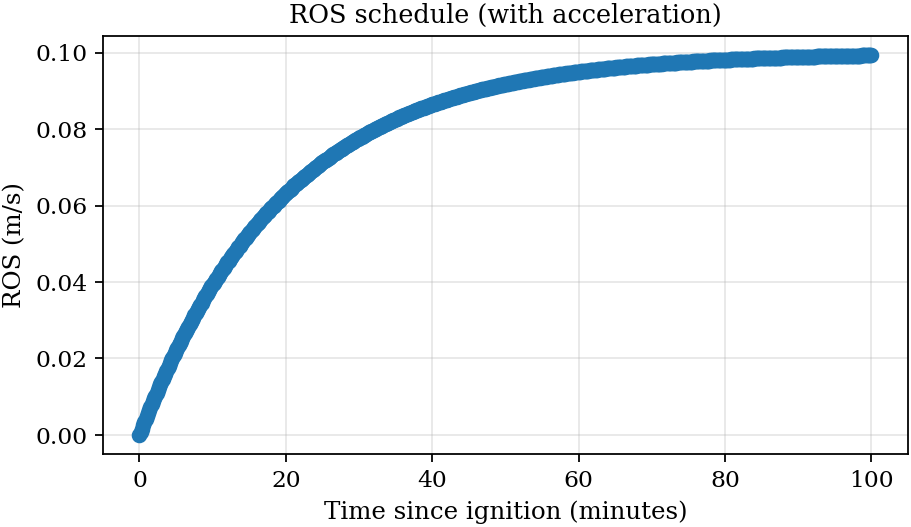

In [121]:

# ROS schedule vs time (includes acceleration from ignition if enabled).
ros_sched = np.asarray(build_ros_schedule(CONFIG), dtype=float)
if ros_sched.ndim == 0:
    ros_sched = ros_sched[None]
t_ros = np.arange(ros_sched.shape[0]) * CONFIG["grid"]["dt_s"] / 60.0
plt.figure(figsize=(6.0, 3.6))
plt.plot(t_ros, ros_sched, marker="o", linewidth=1.4)
plt.xlabel("Time since ignition (minutes)")
plt.ylabel("ROS (m/s)")
plt.title("ROS schedule (with acceleration)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


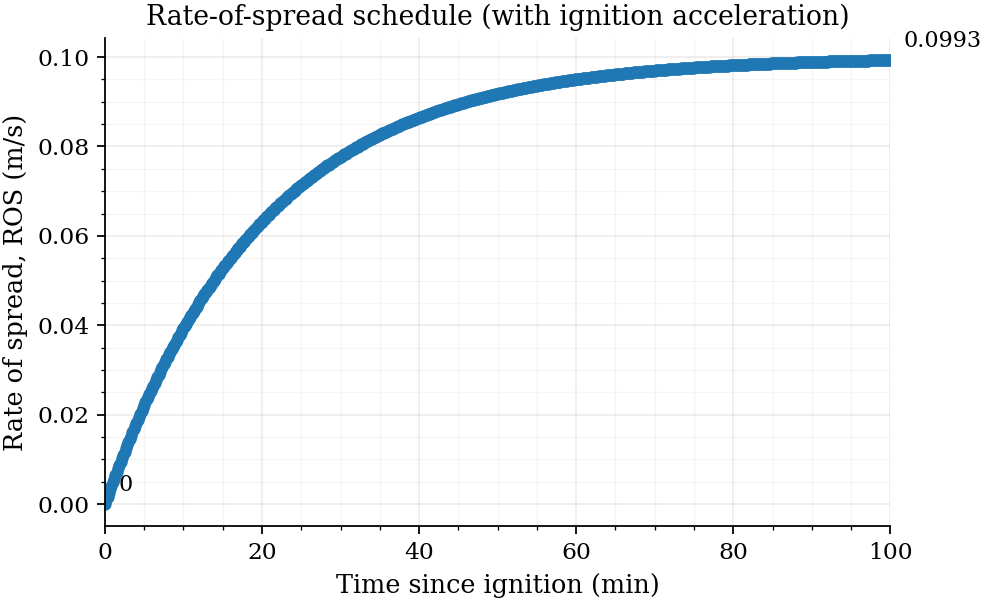

In [122]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -----------------------------
# Publication / LaTeX-friendly styling (no external LaTeX required)
# -----------------------------
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 450,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.02,

    "font.family": "serif",
    "font.size": 11.5,
    "axes.titlesize": 12.0,
    "axes.labelsize": 11.5,
    "legend.fontsize": 10.5,
    "xtick.labelsize": 10.5,
    "ytick.labelsize": 10.5,

    "axes.linewidth": 0.8,
    "xtick.direction": "out",
    "ytick.direction": "out",

    "text.usetex": False,
    "mathtext.fontset": "stix",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# -----------------------------
# ROS schedule vs time (includes acceleration from ignition if enabled)
# -----------------------------
ros_sched = np.asarray(build_ros_schedule(CONFIG), dtype=float)
if ros_sched.ndim == 0:
    ros_sched = ros_sched[None]

dt_min = float(CONFIG["grid"]["dt_s"]) / 60.0
t_ros = np.arange(ros_sched.shape[0]) * dt_min

fig, ax = plt.subplots(figsize=(6.2, 3.8), constrained_layout=True)

ax.plot(t_ros, ros_sched, marker="o", linewidth=1.8, markersize=4.5)

ax.set_xlabel(r"Time since ignition (min)")
ax.set_ylabel(r"Rate of spread, ROS (m/s)")
ax.set_title(r"Rate-of-spread schedule (with ignition acceleration)")

# Clean, paper-style grid + spines
ax.grid(True, which="major", alpha=0.22, linewidth=0.8)
ax.grid(True, which="minor", alpha=0.12, linewidth=0.6)
ax.minorticks_on()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Optional: tighten x-limits to data
ax.set_xlim(float(t_ros.min()), float(t_ros.max()))

# Optional: show start/end annotations (often helpful in papers)
ax.annotate(
    rf"{ros_sched[0]:.3g}",
    xy=(t_ros[0], ros_sched[0]),
    xytext=(6, 6),
    textcoords="offset points",
    fontsize=10,
)
ax.annotate(
    rf"{ros_sched[-1]:.3g}",
    xy=(t_ros[-1], ros_sched[-1]),
    xytext=(6, 6),
    textcoords="offset points",
    fontsize=10,
)

fig.savefig("fig_ros_schedule.pdf")
fig.savefig("fig_ros_schedule.png", dpi=500)
plt.show()


No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params


/var/folders/fr/0hknr11j3dx6vtmvs5kk3gvh0000gn/T/ipykernel_19378/2755045670.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.0, 0.0, 0.93, 0.94])


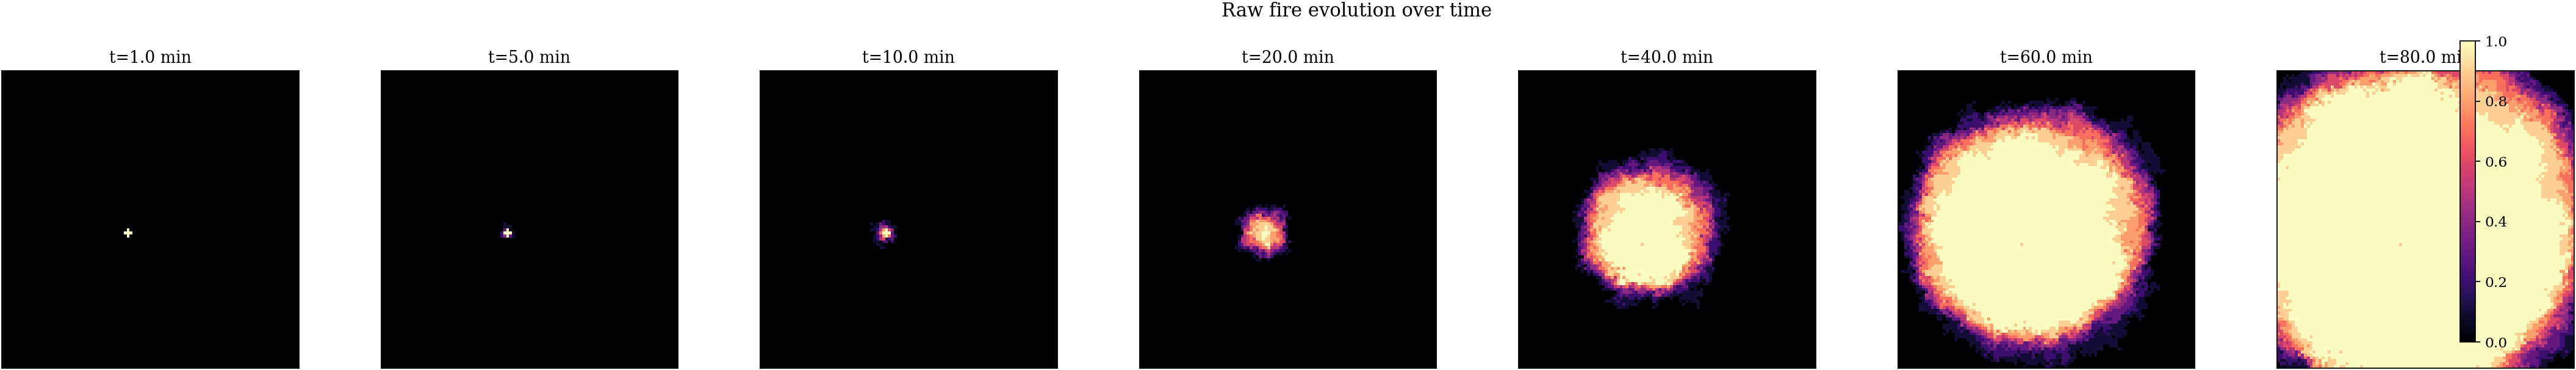

In [123]:

# Baseline fire growth over time (no suppression) to visualise acceleration.
cfg = CONFIG
fm = build_fire_model(cfg, seed=cfg["sweep"]["seed"] + 123)
center = ignition_center_px(cfg)
radius = cfg["ignition"]["radius_km"]
init_batch = fm.init_state_batch(n_sims=cfg["sweep"]["n_mc"], center=center, radius_km=radius)

snap_times = [60.0, 300.0, 600.0,1200,2400,3600,4800]  # seconds
fig, axes = plt.subplots(1, len(snap_times), figsize=(4.2 * len(snap_times), 4.0))
axes = np.atleast_1d(axes)
for ax, T in zip(axes, snap_times):
    state = fm.simulate_from_firestate(
        init_batch,
        T=T,
        n_sims=cfg["sweep"]["n_mc"],
        drone_params=None,
        ros_mps=fm.env.ros_mps,
        wind_coeff=fm.env.wind_coeff,
        diag=True,
        seed=cfg["sweep"]["seed"] + int(T),
        avoid_burning_drop=cfg["fire"]["avoid_burning_drop"],
    )
    p_aff = np.clip(state.burning[0] + state.burned[0], 0.0, 1.0)
    im = ax.imshow(p_aff.T, origin="lower", vmin=0.0, vmax=1.0, cmap="magma")
    ax.set_title(f"t={T/60:.1f} min")
    ax.set_xticks([]); ax.set_yticks([])

fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)

fig.suptitle("Raw fire evolution over time", y=0.98)

fig.tight_layout(rect=[0.0, 0.0, 0.93, 0.94])

plt.show()



No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params


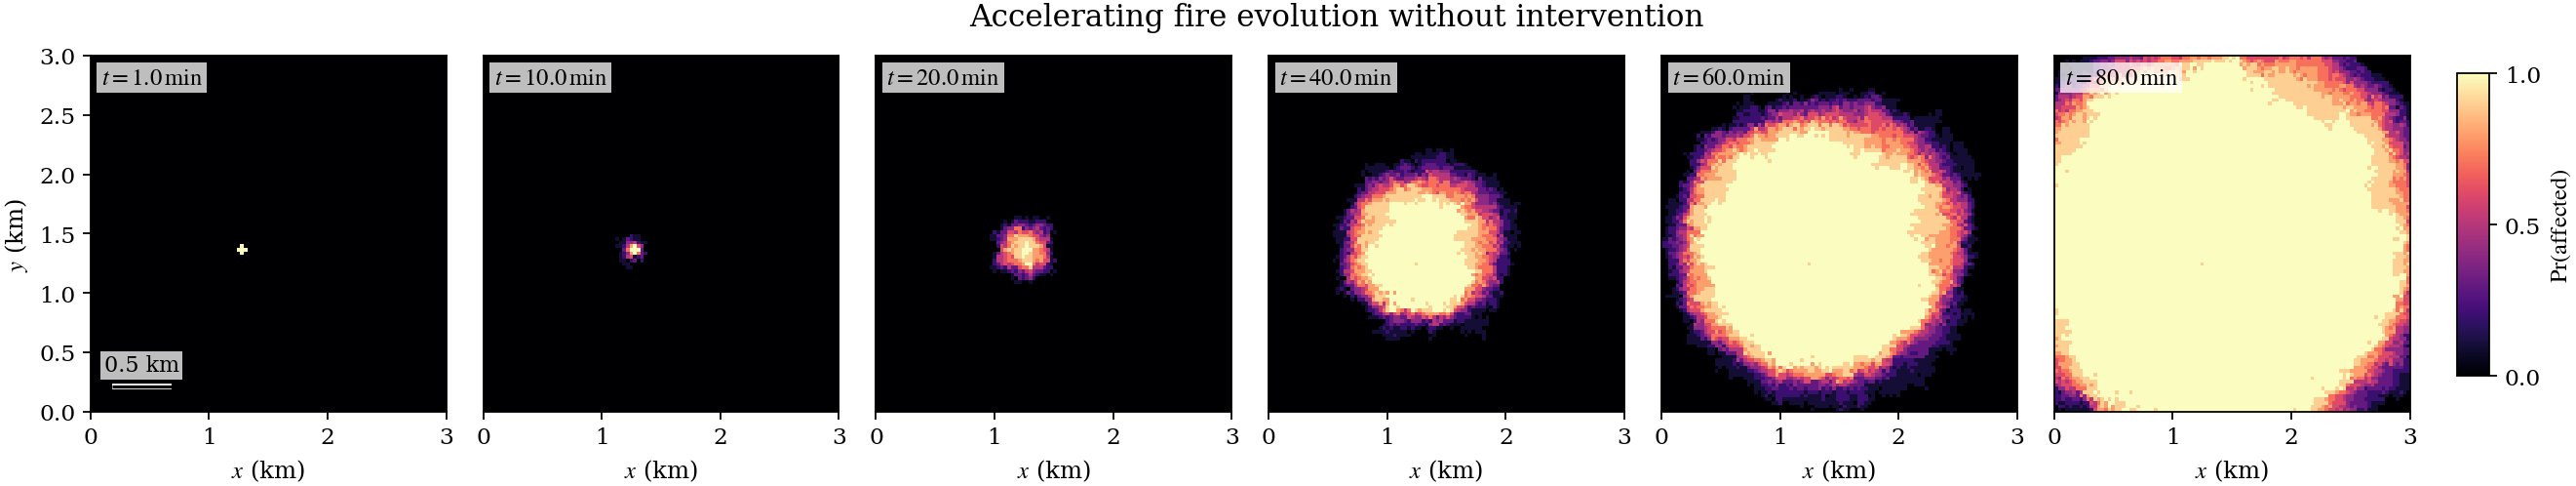

In [129]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -----------------------------
# Publication / LaTeX-friendly styling (no external LaTeX required)
# -----------------------------
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.02,

    "font.family": "serif",
    "font.size": 11.5,
    "axes.titlesize": 11.5,
    "axes.labelsize": 11.0,

    "axes.linewidth": 0.8,
    "xtick.direction": "out",
    "ytick.direction": "out",

    "text.usetex": False,        # robust on clusters / CI
    "mathtext.fontset": "stix",
    "pdf.fonttype": 42,          # embed TrueType fonts
    "ps.fonttype": 42,
})

# -----------------------------
# Baseline fire growth over time (no suppression) to visualise acceleration.
# -----------------------------
cfg = CONFIG
fm = build_fire_model(cfg, seed=cfg["sweep"]["seed"] + 123)
center = ignition_center_px(cfg)
radius = cfg["ignition"]["radius_km"]
init_batch = fm.init_state_batch(n_sims=cfg["sweep"]["n_mc"], center=center, radius_km=radius)

snap_times = [60.0,600.0, 1200.0, 2400.0, 3600.0, 4800.0]  # seconds

# ---- layout: force a single-row strip ----
n = len(snap_times)
nrows, ncols = 1, n

# Panel sizing: tune these two scalars for your paper layout
panel_w = 2.85   # width per panel (inches)
panel_h = 2.85   # height per panel
fig_w = panel_w * ncols
fig_h = panel_h * nrows

fig, axes = plt.subplots(1, ncols, figsize=(fig_w, fig_h), constrained_layout=False)
axes = np.atleast_1d(axes)

# Leave space for shared colorbar and title
fig.subplots_adjust(left=0.03, right=0.905, bottom=0.06, top=0.86, wspace=0.06)

# Domain extent (km) for scientific axes (removes ambiguity)
domain_km = float(fm.env.domain_km) if hasattr(fm.env, "domain_km") else None
extent_km = (0.0, domain_km, 0.0, domain_km) if domain_km is not None else None

# ---- draw panels ----
im = None
for c, T in enumerate(snap_times):
    ax = axes[c]

    state = fm.simulate_from_firestate(
        init_batch,
        T=T,
        n_sims=cfg["sweep"]["n_mc"],
        drone_params=None,
        ros_mps=fm.env.ros_mps,
        wind_coeff=fm.env.wind_coeff,
        diag=True,
        seed=cfg["sweep"]["seed"] + int(T),
        avoid_burning_drop=cfg["fire"]["avoid_burning_drop"],
    )

    p_aff = np.clip(state.burning[0] + state.burned[0], 0.0, 1.0)

    im = ax.imshow(
        p_aff.T,
        origin="lower",
        vmin=0.0, vmax=1.0,
        cmap="magma",
        interpolation="nearest",
        rasterized=True,
        extent=extent_km,
    )

    stamp_time(ax, T)
    ax.set_aspect("equal", adjustable="box")

    # Axes: keep uncluttered; only leftmost shows y labels
    if extent_km is not None:
        if c == 0:
            ax.set_ylabel(r"$y$ (km)")
        else:
            ax.set_yticks([])

        # For single row, either show x label on all or only a couple panels
        ax.set_xlabel(r"$x$ (km)")
        # If you prefer fewer x labels, uncomment:
        # if c not in (0, ncols - 1):
        #     ax.set_xlabel("")
    else:
        ax.set_xticks([])
        ax.set_yticks([])

# Shared colorbar (manual axis to keep spacing stable)
cax = fig.add_axes([0.92, 0.14, 0.012, 0.68])  # [left, bottom, width, height] in figure coords
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"$\Pr(\mathrm{affected})$")
cbar.set_ticks([0.0, 0.5, 1.0])

# Optional: scale bar in first panel
if extent_km is not None:
    L = domain_km / 5.0
    L = 1.0 if L >= 1.0 else 0.5
    add_scalebar(axes[0], L_km=L)

fig.suptitle(r"Accelerating fire evolution without intervention", y=0.98, fontsize=14)

fig.savefig("fig_fire_evolution_snapshots_row.pdf")
fig.savefig("fig_fire_evolution_snapshots_row.png", dpi=500)

plt.show()


In [125]:

# Define the grid to explore (detection delay x drone count).
sweep_delays = CONFIG["sweep"]["time_of_arrival_s"]
sweep_drones = CONFIG["sweep"]["drone_counts"]
SWEEP_GRID = [(d, n) for d in sweep_delays for n in sweep_drones]
print(f"Total combinations: {len(SWEEP_GRID)}")
print("Examples:", SWEEP_GRID[: min(6, len(SWEEP_GRID))])


Total combinations: 35
Examples: [(300.0, 2), (300.0, 4), (300.0, 6), (300.0, 8), (300.0, 10), (600.0, 2)]


No drone_params
No drone_params


/var/folders/fr/0hknr11j3dx6vtmvs5kk3gvh0000gn/T/ipykernel_19378/2796475804.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


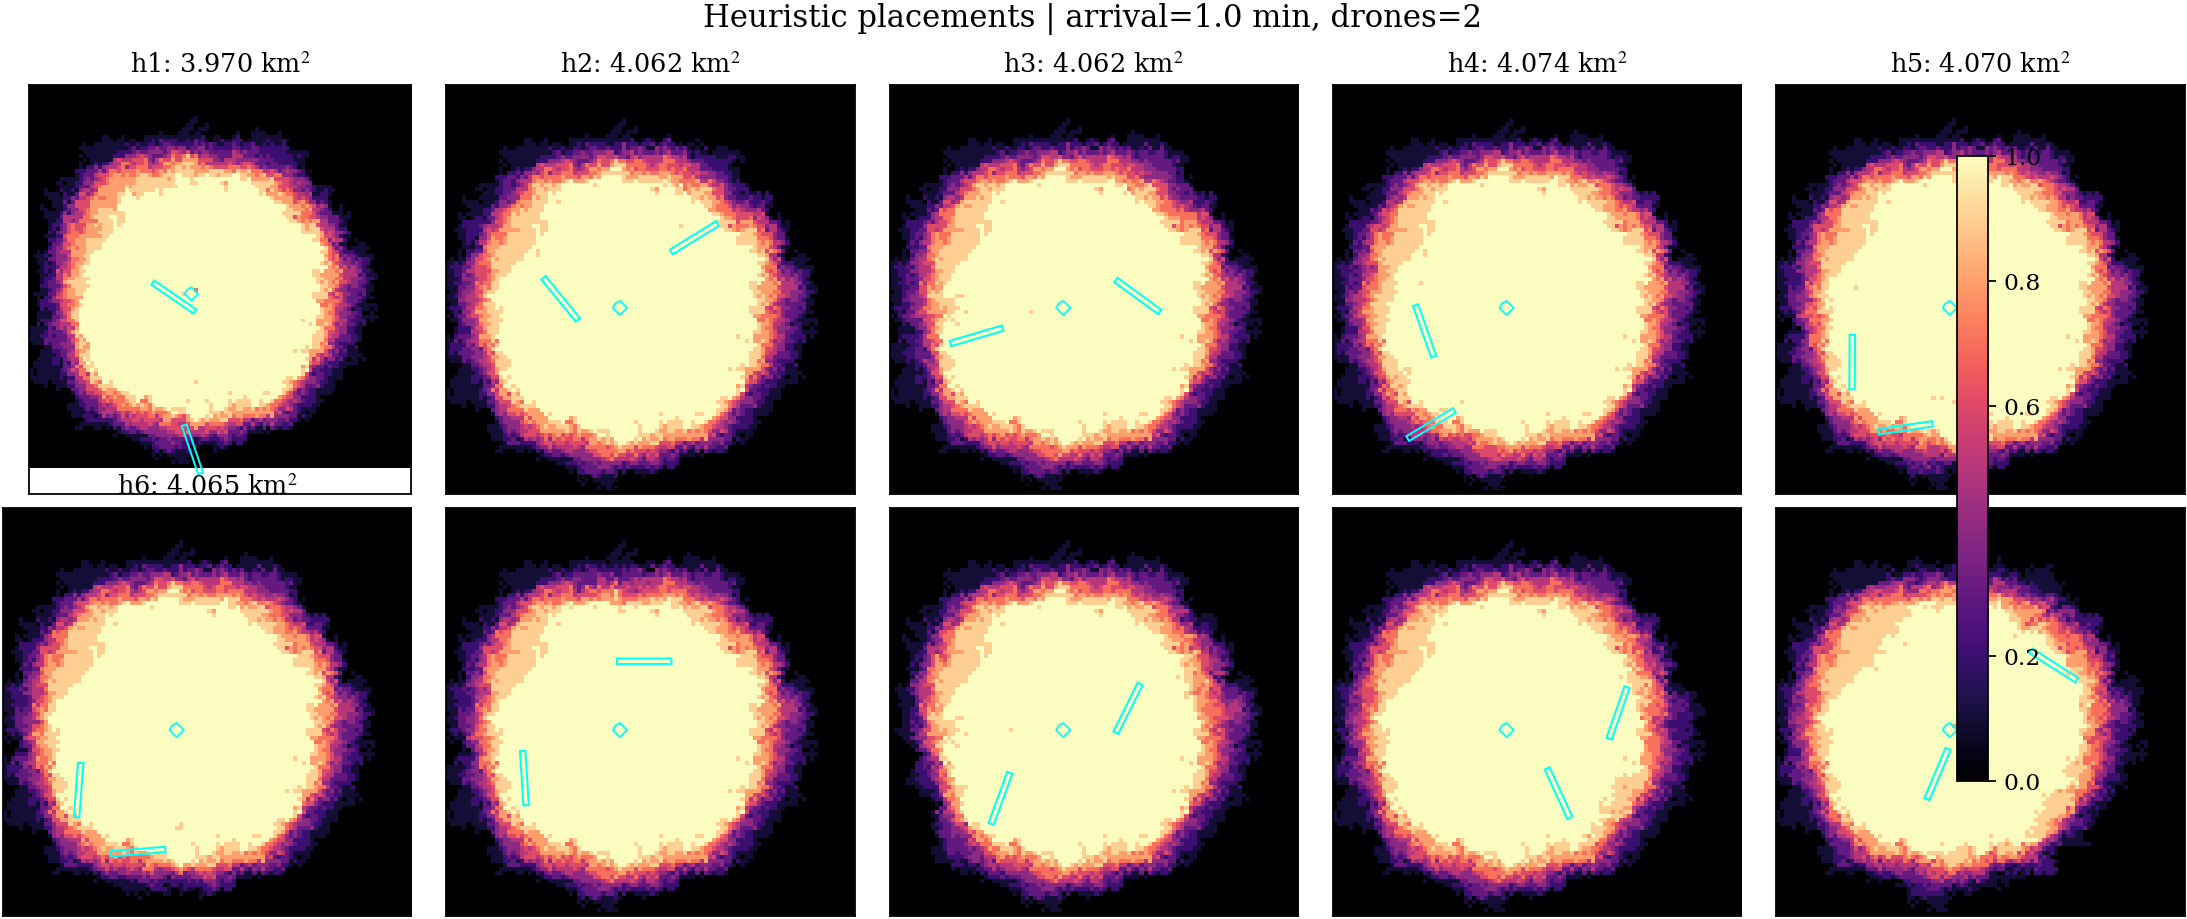

In [126]:

# Heuristic gallery: 10 heuristic placements (2x5 grid) for a representative setting.
heur_setting = CONFIG["diagnostics"]["settings"][0]
heur_delay, heur_nd = heur_setting
bo_h, detected_h = make_bo_for_setting(heur_delay, heur_nd, seed_offset=11)
bo_h.setup_search_grid_sr(**sr_kwargs(CONFIG))

p_detect = np.clip(detected_h.burning[0] + detected_h.burned[0], 0.0, 1.0)

# Sample heuristics
thetas = bo_h.sample_initial_thetas(
    n_init=CONFIG["heuristics"]["n_evals"],
    strategy="heuristic",
    heuristic_random_frac=CONFIG["heuristics"].get("heuristic_random_frac", 0.0),
    heuristic_kwargs=CONFIG["heuristics"].get("heuristic_kwargs", {}),
    heuristic_value_prob=CONFIG["heuristics"].get("heuristic_value_prob", 0.5),
    heuristic_uniform_ring_prob=CONFIG["heuristics"].get("heuristic_uniform_ring_prob", 0.25),
    heuristic_downwind_prob=CONFIG["heuristics"].get("heuristic_downwind_prob", 0.25),
    heuristic_mix_prob=CONFIG["heuristics"].get("heuristic_mix_prob", 0.15),
    heuristic_mix_ratio=CONFIG["heuristics"].get("heuristic_mix_ratio", 0.5),
)

dx = bo_h.fire_model.dx
w_cells = CONFIG["fire"]["drop_w_km"] / dx
h_cells = CONFIG["fire"]["drop_h_km"] / dx

fig, axes = plt.subplots(2, 5, figsize=CONFIG["plots"]["heuristic_figsize"])
axes = axes.ravel()
legend_handles = []
for idx, (ax, theta) in enumerate(zip(axes, np.atleast_2d(thetas))):
    obj, p_aff, _ = eval_theta_fields(bo_h, theta)
    im = ax.imshow(p_aff.T, origin="lower", vmin=0, vmax=1, cmap="magma")
    # Outline detected fire
    cs = ax.contour(p_detect.T, levels=[0.25], colors='cyan', linewidths=0.8)
    colls = getattr(cs, 'collections', None)
    if colls:
        colls[0].set_label('detected fire')
        if colls[0] not in legend_handles:
            legend_handles.append(colls[0])
    # Drone rectangles
    params = bo_h.decode_theta(theta)
    for j, (x0, y0, phi) in enumerate(params):
        rect = mpatches.Rectangle(
            (x0 - 0.5 * w_cells, y0 - 0.5 * h_cells),
            width=w_cells,
            height=h_cells,
            angle=np.degrees(phi),
            fill=False,
            edgecolor='cyan',
            linewidth=0.9,
        )
        ax.add_patch(rect)
        if rect not in legend_handles:
            #rect.set_label('drone drop footprint')
            legend_handles.append(rect)
    ax.set_title(f"h{idx+1}: {obj:.3f} km$^2$")
    ax.set_xticks([]); ax.set_yticks([])

#if legend_handles:
    #fig.legend(handles=legend_handles, loc='upper center', ncol=len(legend_handles))
fig.suptitle(f"Heuristic placements | arrival={heur_delay/60:.1f} min, drones={heur_nd}")
fig.colorbar(im, ax=axes.tolist(), fraction=0.018)
plt.tight_layout()
plt.show()


In [127]:

# BO diagnostics per selected settings (hyperparameters, learning curve, scenario outcome).
diag_settings = CONFIG["diagnostics"]["settings"]
records_diag = []
for (arrival_s, n_drones) in diag_settings:
    print(f"=== BO diagnostic: arrival={arrival_s/60:.1f} min | drones={n_drones} ===")
    bo, arrival_state = make_bo_for_setting(arrival_s, n_drones, seed_offset=int(arrival_s + n_drones))
    bo.setup_search_grid_sr(**sr_kwargs(CONFIG))

    best_theta, best_params, best_y, history, y_nexts, y_bests = bo.run_bayes_opt(
        n_init=CONFIG["bo"]["n_init"],
        n_iters=CONFIG["bo"]["n_iters"],
        n_candidates=CONFIG["bo"]["n_candidates"],
        xi=CONFIG["bo"]["xi"],
        verbose=False,
        print_every=0,
        use_ard_kernel=CONFIG["bo"].get("use_ard_kernel", False),
        init_strategy=CONFIG["bo"]["init_strategy"],
        init_heuristic_random_frac=CONFIG["bo"]["init_heuristic_random_frac"],
        init_heuristic_kwargs=CONFIG["bo"]["init_heuristic_kwargs"],
        init_heuristic_value_prob=CONFIG["bo"]["init_heuristic_value_prob"],
        init_heuristic_uniform_ring_prob=CONFIG["bo"]["init_heuristic_uniform_ring_prob"],
        init_heuristic_downwind_prob=CONFIG["bo"]["init_heuristic_downwind_prob"],
        candidate_strategy=CONFIG["bo"]["candidate_strategy"],
        candidate_qmc=CONFIG["bo"].get("candidate_qmc", "sobol"),
        candidate_local_frac=CONFIG["bo"]["candidate_local_frac"],
        candidate_local_top_k=CONFIG["bo"]["candidate_local_top_k"],
        candidate_local_sigma_s=CONFIG["bo"]["candidate_local_sigma_s"],
        candidate_local_sigma_r=CONFIG["bo"]["candidate_local_sigma_r"],
        candidate_local_sigma_delta_rad=CONFIG["bo"]["candidate_local_sigma_delta_rad"],
        candidate_local_resample_delta_prob=CONFIG["bo"]["candidate_local_resample_delta_prob"],
        K_grid=CONFIG["search_grid"]["K_grid"],
        boundary_field=CONFIG["search_grid"]["boundary_field"],
        n_r=CONFIG["search_grid"]["n_r"],
        smooth_iters=CONFIG["search_grid"]["smooth_iters"],
        omega=CONFIG["search_grid"]["omega"],
    )

    gp = fit_gp_from_history(history, use_ard=CONFIG["bo"].get("use_ard_kernel", False))
    print("GP kernel_:", gp.kernel_)

    plot_learning_curve(y_bests, title=f"BO learning | {arrival_s/60:.1f} min, {n_drones} drones")
    bo.plot_evolved_firestate(best_theta, n_sims=CONFIG["plots"]["bo_outcome_n_sims"], title_prefix=f"arrival={arrival_s/60:.1f}m | D={n_drones}")

    records_diag.append(
        {
            "time_of_arrival_s": arrival_s,
            "n_drones": n_drones,
            "best_burned_area": best_y,
            "baseline_area": expected_burned_km2(bo.fire_model, bo.init_firestate),
            "relative_reduction": np.nan,
            "kernel": str(gp.kernel_),
        }
    )

diag_df = pd.DataFrame(records_diag)
diag_df


=== BO diagnostic: arrival=1.0 min | drones=2 ===
No drone_params
No drone_params


KeyboardInterrupt: 

In [ ]:

# Full sweep across grid; aggregate results and phase diagrams.
records = []
for arrival_s, n_drones in SWEEP_GRID:
    bo, arrival_state = make_bo_for_setting(arrival_s, n_drones, seed_offset=int(arrival_s + n_drones + 99))
    best_theta, best_params, best_y, history, y_nexts, y_bests = bo.run_bayes_opt(
        n_init=CONFIG["bo"]["n_init"],
        n_iters=CONFIG["bo"]["n_iters"],
        n_candidates=CONFIG["bo"]["n_candidates"],
        xi=CONFIG["bo"]["xi"],
        verbose=False,
        print_every=0,
        use_ard_kernel=CONFIG["bo"].get("use_ard_kernel", False),
        init_strategy=CONFIG["bo"]["init_strategy"],
        init_heuristic_random_frac=CONFIG["bo"]["init_heuristic_random_frac"],
        init_heuristic_kwargs=CONFIG["bo"]["init_heuristic_kwargs"],
        init_heuristic_value_prob=CONFIG["bo"]["init_heuristic_value_prob"],
        init_heuristic_uniform_ring_prob=CONFIG["bo"]["init_heuristic_uniform_ring_prob"],
        init_heuristic_downwind_prob=CONFIG["bo"]["init_heuristic_downwind_prob"],
        candidate_strategy=CONFIG["bo"]["candidate_strategy"],
        candidate_qmc=CONFIG["bo"].get("candidate_qmc", "sobol"),
        candidate_local_frac=CONFIG["bo"]["candidate_local_frac"],
        candidate_local_top_k=CONFIG["bo"]["candidate_local_top_k"],
        candidate_local_sigma_s=CONFIG["bo"]["candidate_local_sigma_s"],
        candidate_local_sigma_r=CONFIG["bo"]["candidate_local_sigma_r"],
        candidate_local_sigma_delta_rad=CONFIG["bo"]["candidate_local_sigma_delta_rad"],
        candidate_local_resample_delta_prob=CONFIG["bo"]["candidate_local_resample_delta_prob"],
        K_grid=CONFIG["search_grid"]["K_grid"],
        boundary_field=CONFIG["search_grid"]["boundary_field"],
        n_r=CONFIG["search_grid"]["n_r"],
        smooth_iters=CONFIG["search_grid"]["smooth_iters"],
        omega=CONFIG["search_grid"]["omega"],
    )

    baseline = bo.fire_model.simulate_from_firestate(
        bo.init_firestate,
        T=bo.evolution_time_s,
        n_sims=cfg["sweep"]["n_mc"],
        drone_params=None,
        ros_mps=bo.fire_model.env.ros_mps,
        wind_coeff=bo.fire_model.env.wind_coeff,
        diag=bo.fire_model.env.diag,
        seed=cfg["sweep"]["seed"] + 12345,
    )
    baseline_area = expected_burned_km2(bo.fire_model, baseline)
    rel_red = 1.0 - float(best_y) / baseline_area

    records.append(
        {
            "time_of_arrival_s": arrival_s,
            "n_drones": n_drones,
            "baseline_area": baseline_area,
            "best_burned_area": float(best_y),
            "relative_reduction": rel_red,
            "best_trace": y_bests,
            "best_theta": best_theta,
        }
    )

results_df = pd.DataFrame(records).sort_values(["time_of_arrival_s", "n_drones"]).reset_index(drop=True)
results_df


No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params


KeyboardInterrupt: 

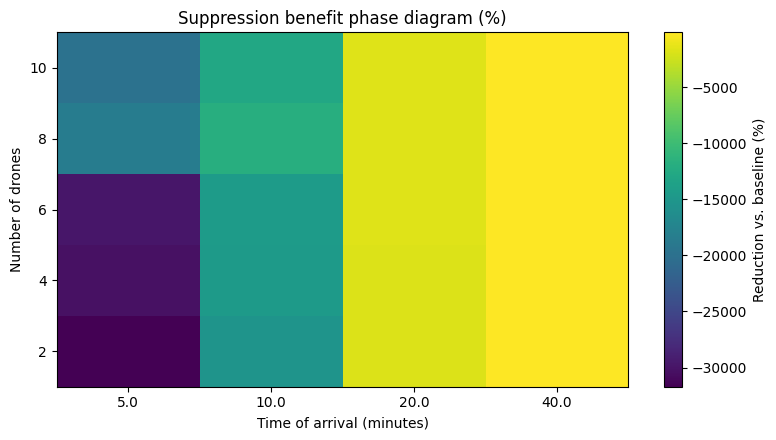

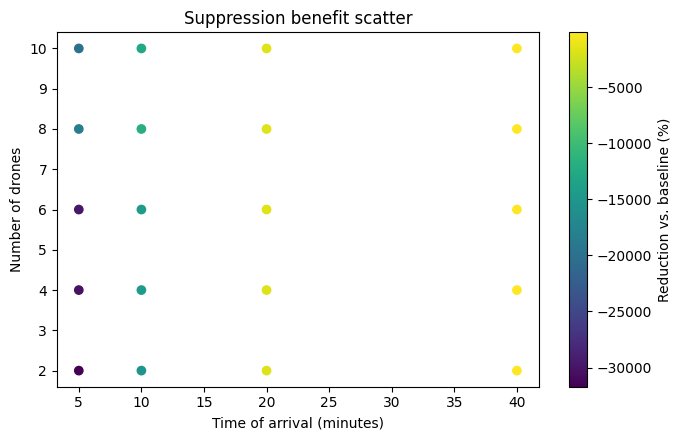

Best overall setting:
time_of_arrival_s       2400.0
n_drones                    10
best_burned_area       2.70171
baseline_area          1.32912
relative_reduction   -1.032706
Name: 19, dtype: object


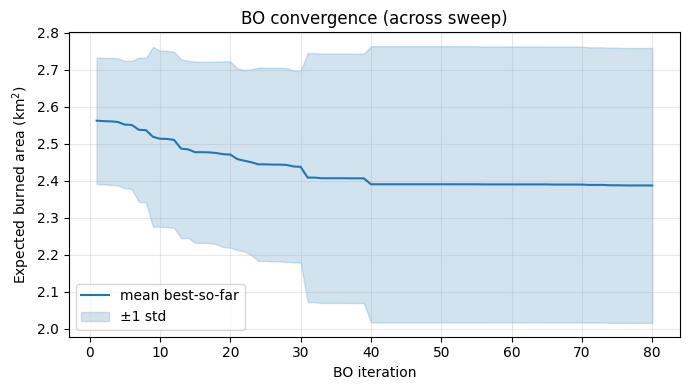

In [ ]:

# Cross-setting visualisation: phase diagram, best overall, and learning stats.
plot_phase_diagram(results_df, title="Suppression benefit phase diagram (%)")

# Scatter of reductions
fig, ax = plt.subplots(figsize=(7, 4.5))
sc = ax.scatter(results_df["time_of_arrival_s"] / 60.0, results_df["n_drones"], c=results_df["relative_reduction"] * 100.0, cmap="viridis")
ax.set_xlabel("Time of arrival (minutes)")
ax.set_ylabel("Number of drones")
ax.set_title("Suppression benefit scatter")
fig.colorbar(sc, ax=ax, label="Reduction vs. baseline (%)")
plt.tight_layout()
plt.show()

# Best overall
best_idx = results_df["relative_reduction"].idxmax()
best_row = results_df.loc[best_idx]
print("Best overall setting:")
print(best_row[["time_of_arrival_s", "n_drones", "best_burned_area", "baseline_area", "relative_reduction"]])

# Learning curve statistics
max_len = max(len(t) for t in results_df["best_trace"])
mat = np.full((len(results_df), max_len), np.nan)
for i, trace in enumerate(results_df["best_trace"]):
    mat[i, : len(trace)] = trace
mean_trace = np.nanmean(mat, axis=0)
std_trace = np.nanstd(mat, axis=0)
fig2, ax2 = plt.subplots(figsize=(7, 4))
ax2.plot(range(1, len(mean_trace) + 1), mean_trace, label="mean best-so-far")
ax2.fill_between(range(1, len(mean_trace) + 1), mean_trace - std_trace, mean_trace + std_trace, color="tab:blue", alpha=0.2, label="±1 std")
ax2.set_xlabel("BO iteration")
ax2.set_ylabel("Expected burned area (km$^2$)")
ax2.set_title("BO convergence (across sweep)")
ax2.grid(alpha=0.3)
ax2.legend()
plt.tight_layout()
plt.show()



### Notes and extensions
- All parameters live in the CONFIG cell; adjust there to explore other grids, horizons, or BO/heuristic settings.
- Increase `diagnostics.settings` to get per-run plots for more cases (beware runtime). Reduce `n_iters`/`n_candidates`/`n_mc` if you need faster sweeps.
- To focus on heavier/lighter fires while keeping evidence alignment, adjust `fire.ros_mps` and `fire.wind_coeff` together.
